<a href="https://colab.research.google.com/github/northpr/tensorflow-resources/blob/main/object_detection/vgg19_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Detection using HAAR Cascade Algorithm

## Preparation

In [1]:
!gdown --id 1Tmb5kIB3lIEpdWkfVJ6VTZ9wqNv6gr-5
!gdown --id 1bdpuIjIz0_SYTW7JQJvblqZkOd70XJI9
!wget https://raw.githubusercontent.com/northpr/helper_function/master/tensorflow/helper_tensorflow.py

from helper_tensorflow import *

unzip_data("facemask_dataset.zip")
unzip_data("full_face_mask.zip")

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Tmb5kIB3lIEpdWkfVJ6VTZ9wqNv6gr-5
To: /content/facemask_dataset.zip
100% 352M/352M [00:07<00:00, 47.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bdpuIjIz0_SYTW7JQJvblqZkOd70XJI9
To: /content/full_face_mask.zip
100% 418M/418M [00:09<00:00, 45.0MB/s]
--2022-11-10 11:46:43--  https://raw.githubusercontent.com/northpr/helper_function/master/tensorflow/helper_tensorflow.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.1

In [2]:
walk_through_dir("./facemask_dataset")

There are 3 directories and 0 images in './facemask_dataset'.
There are 2 directories and 0 images in './facemask_dataset/Validation'.
There are 0 directories and 400 images in './facemask_dataset/Validation/WithoutMask'.
There are 0 directories and 400 images in './facemask_dataset/Validation/WithMask'.
There are 2 directories and 0 images in './facemask_dataset/Test'.
There are 0 directories and 509 images in './facemask_dataset/Test/WithoutMask'.
There are 0 directories and 483 images in './facemask_dataset/Test/WithMask'.
There are 2 directories and 0 images in './facemask_dataset/Train'.
There are 0 directories and 5000 images in './facemask_dataset/Train/WithoutMask'.
There are 0 directories and 5000 images in './facemask_dataset/Train/WithMask'.


In [3]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = "facemask_dataset"

dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
  for status in os.listdir(path+"/"+where):
    for image in glob.glob(path+"/"+where+"/"+status+"/"+"*.png"):
      dataset["image_path"].append(image)
      dataset["mask_status"].append(status)
      dataset["where"].append(where)

df = pd.DataFrame(dataset)
df.head()

,image_path,mask_status,where
0,facemask_dataset/Validation/WithoutMask/1360.png,WithoutMask,Validation
1,facemask_dataset/Validation/WithoutMask/4585.png,WithoutMask,Validation
2,facemask_dataset/Validation/WithoutMask/971.png,WithoutMask,Validation
3,facemask_dataset/Validation/WithoutMask/5338.png,WithoutMask,Validation
4,facemask_dataset/Validation/WithoutMask/1984.png,WithoutMask,Validation


In [5]:
# Download Opencv
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P drive/gaze

cascades_path = 'drive/gaze/'
face_model = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')

--2022-11-10 11:46:54--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘drive/gaze/haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.006s  

2022-11-10 11:46:56 (139 MB/s) - ‘drive/gaze/haarcascade_frontalface_default.xml’ saved [930127/930127]



## Visualizations

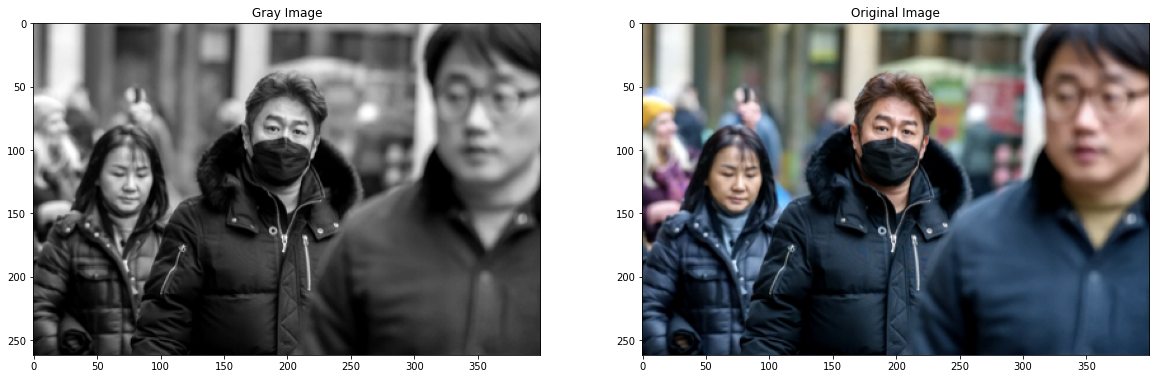

In [6]:
img = cv2.imread("full_face_mask/images/maksssksksss244.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1);plt.imshow(img_gray, cmap="gray");plt.title("Gray Image");
plt.subplot(1,2,2);plt.imshow(img_rgb);plt.title("Original Image");

## Test Haarcascade

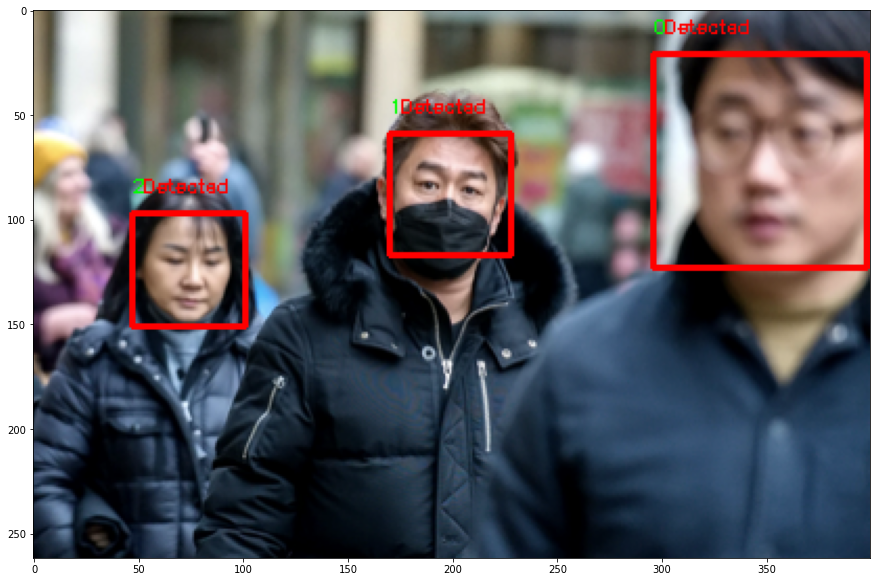

In [7]:
# Returns the x, y, w, h co-ordinates as numpy arrays for all the detected faces
detected_face = face_model.detectMultiScale(img_gray)
img_rgb_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Drawing rectangle box
for index, (x, y, w, h) in enumerate(detected_face):
  cv2.putText(img_rgb_test, str(index), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=(0,255,0))
  cv2.putText(img_rgb_test, 'Detected', (x+5,y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=(255,0,0))
  cv2.rectangle(img_rgb_test, (x,y), (x+w, y+h), (255,0,0), 2)

# Display the image
plt.figure(figsize = (15,15))
plt.imshow(img_rgb_test,cmap="gray")

# Detecting social distance

In [8]:
dist = distance.euclidean(detected_face[0][:2], detected_face[1][:2])
print(dist)

131.60547101089682


I:0
J:1
Face 0:[296  21 102 102]
Face 1:[170  59  58  58]
[0, 0, 0]
J:2
Face 0:[296  21 102 102]
Face 2:[47 97 54 54]
[0, 0, 0]
I:1
J:2
Face 1:[170  59  58  58]
Face 2:[47 97 54 54]
[0, 1, 1]
Label outside forloop:[0, 1, 1]


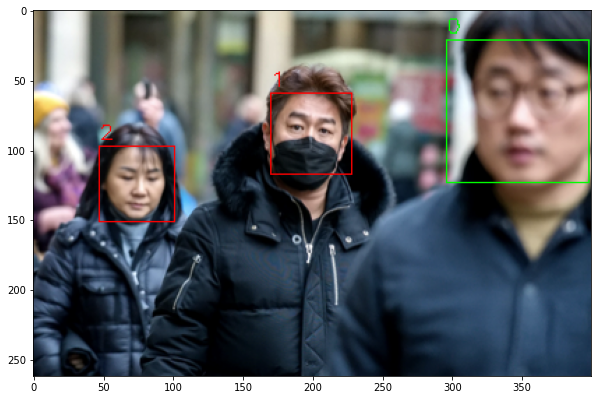

In [9]:
if len(detected_face) >= 2:
  label =[0 for i in range(len(detected_face))]
  
  # Getting the distance from one image to rest of the image
  for i in range(len(detected_face)-1):
    print(f"I:{i}")
    for j in range(i+1, len(detected_face)):
      print(f"J:{j}")
      print(f"Face {i}:{detected_face[i]}")
      print(f"Face {j}:{detected_face[j]}")
      # Using x,y to calcuate the distance between two faces
      dist = distance.euclidean(detected_face[i][:2], detected_face[j][:2])
      # Checking if the distance is less than 180 cm
      if dist < 130:
        # If tless than 180 cm, flag the respective image
        label[i] = 1
        label[j] = 1
      print(label)
  new_img_rgb = img_rgb.copy()
  print(f"Label outside forloop:{label}")
  # Coloring the image
  for i in range(len(detected_face)):
    (x, y, w, h) = detected_face[i]
    if label[i] == 1:
      cv2.rectangle(new_img_rgb,(x,y),(x+w,y+h),(255,0,0),1)
      cv2.putText(new_img_rgb, str(i), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,0,0))
    else:
      cv2.rectangle(new_img_rgb,(x,y),(x+h,y+h),(0,255,0),1)
      cv2.putText(new_img_rgb, str(i), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,255,0))

  
  plt.figure(figsize=(10,10))
  plt.imshow(new_img_rgb)
else:
  print("Number of faces detected is less than 2")

## Using VGG19 for mask detection

[Keras.io: VGG16 and VGG19](https://keras.io/api/applications/vgg/)
Default input size for this model is 224x224

In [10]:
from tensorflow import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras import layers
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# Load train and test set
train_dir = "/content/facemask_dataset/Train"
test_dir = "/content/facemask_dataset/Test"
val_dir = "/content/facemask_dataset/Validation"

## Create callbacks

In [12]:
early_stopping = callbacks_early_stopping(monitor="accuracy", patience=2, verbose=1)

## Data Augmentation

In [13]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    batch_size=32,
                                                    target_size=(224,224),
                                                    class_mode="categorical",
                                                    seed=123)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  class_mode="categorical",
                                                  seed=123)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  class_mode="categorical",
                                                  seed=123)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Model 0: Building VGG19 transfer learning model


In [14]:
# Download VGG19
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))

80134624/80134624 [==============================] - 4s 0us/step


In [15]:
for layer in  vgg19.layers:
  layer.trainable = False

inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = vgg19(inputs)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
outputs = layers.Dense(2, activation="sigmoid", name="output_layer")(x)
model_vgg = keras.Model(inputs, outputs)

model_vgg.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 output_layer (Dense)        (None, 2)                 130       
                                                                 
Total params: 21,630,210
Trainable params: 1,605,826
Non-trainable params: 20,024,384
_________________________________________________________________


In [16]:
# Fit model_vgg
history_0 = model_vgg.fit(train_generator,
              epochs=5,
              steps_per_epoch=int(len(train_generator)*0.25),
              validation_data=val_generator,
              validation_steps=int(len(val_generator)*0.25),
              callbacks=[early_stopping])

Epoch 1/5
78/78 [==============================] - 45s 437ms/step - loss: 1.7291 - accuracy: 0.8810 - val_loss: 0.0940 - val_accuracy: 0.9635
Epoch 2/5
78/78 [==============================] - 33s 427ms/step - loss: 0.1109 - accuracy: 0.9768 - val_loss: 0.0202 - val_accuracy: 0.9948
Epoch 3/5
78/78 [==============================] - 34s 438ms/step - loss: 0.0944 - accuracy: 0.9722 - val_loss: 0.0712 - val_accuracy: 0.9740
Epoch 4/5
78/78 [==============================] - 33s 427ms/step - loss: 0.0754 - accuracy: 0.9794 - val_loss: 0.0138 - val_accuracy: 0.9896
Epoch 5/5
78/78 [==============================] - 33s 425ms/step - loss: 0.1073 - accuracy: 0.9756 - val_loss: 0.0150 - val_accuracy: 0.9948


In [17]:
evaluate_0 = model_vgg.evaluate(test_generator)

31/31 [==============================] - 6s 177ms/step - loss: 0.0265 - accuracy: 0.9950


### Testing the model

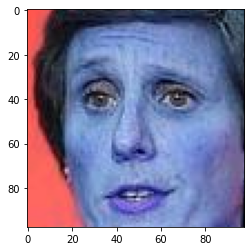

In [18]:
test_mask_img = cv2.imread("/content/facemask_dataset/Train/WithoutMask/1045.png")
plt.imshow(test_mask_img)

In [19]:
test_mask_img = cv2.resize(test_mask_img, (224,224))
test_mask_img = np.reshape(test_mask_img,[1,224,224,3])
test_mask_img = test_mask_img/255.0
model_vgg.predict(test_mask_img)

1/1 [==============================] - 1s 763ms/step


array([[3.9801922e-05, 9.9999487e-01]], dtype=float32)

# Integrating with HAAR Cascae

i: 0
j: 1
j: 2
i: 1
j: 2
Label: [0, 1, 1]
1/1 [==============================] - 0s 15ms/step


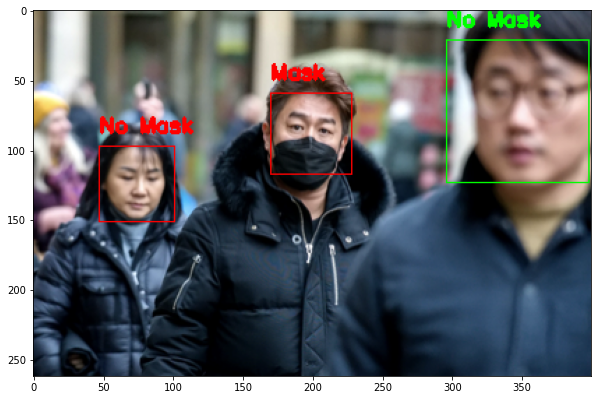

In [42]:
mask_label = {0:"Mask", 1:"No Mask"}
dist_label = {0:(0,255,0), 1:(255,0,0)}

# Finding the distance between person who has masked by using Euclidean
if len(detected_face) >= 2:
  label = [0 for i in range(len(detected_face))]
  for i in range(len(detected_face)-1):
    print(f"i: {i}")
    for j in range(i+1, len(detected_face)):
      print(f"j: {j}")
      dist = distance.euclidean(detected_face[i][0:2], detected_face[j][0:2])
      if dist < 130:
        label[i] = 1
        label[j] = 1
        print(f"Label: {label}")

  new_img_rgb = img_rgb.copy()

  for i in range(len(detected_face)):
    (x,y,w,h) = detected_face[i]
    # Preparing the image and make a predict
    crop = new_img_rgb[y:y+h, x:x+w]
    crop = cv2.resize(crop, (224,224))
    crop = np.reshape(crop,[1,224,224,3])/255.0
    mask_result = model_vgg.predict(crop)

    # Writing a text and draw of the detector
    cv2.putText(new_img_rgb, mask_label[mask_result.argmax()],
                (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, dist_label[label[i]],2)
    cv2.rectangle(new_img_rgb, (x,y),(x+w, y+h), dist_label[label[i]],1)
  plt.figure(figsize=(10,10))
  plt.imshow(new_img_rgb)
else: print("Number of faces detected are less than 2")
